In [1]:
import os

DATA_ROOT = "data"  # adjust if classical/ and jazz/ are inside a folder

GENRES = ["classical", "jazz"]

for g in GENRES:
    print(g, "→", len(os.listdir(os.path.join(DATA_ROOT, g))), "files")



classical → 100 files
jazz → 100 files


In [2]:
import numpy as np
import librosa

import numpy as np
import librosa

# Audio / feature config
SR = 22050       # sample rate for loading
DURATION = 30    # seconds (your files are 30s)
N_MFCC = 20      # number of MFCC coefficients

def extract_features(file_path, n_mfcc=N_MFCC, sr=SR, duration=DURATION):
    """
    Load an audio file and return a 1D feature vector:
    [mean(mfcc_1..n), std(mfcc_1..n)] -> length 2 * n_mfcc
    """
    # Load audio as mono
    y, sr = librosa.load(file_path, sr=sr, duration=duration)

    # MFCCs: shape (n_mfcc, time_frames)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Aggregate over time
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Concatenate: 20 means + 20 stds = 40 features
    features = np.concatenate([mfcc_mean, mfcc_std], axis=0)
    return features


In [3]:
X = []
y = []

for label_idx, genre in enumerate(GENRES):
    genre_folder = os.path.join(DATA_ROOT, genre)
    print(f"Processing genre: {genre} (label={label_idx})")

    for fname in os.listdir(genre_folder):
        if not fname.lower().endswith(".wav"):
            continue  # skip anything that isn't a wav file

        fpath = os.path.join(genre_folder, fname)
        try:
            feats = extract_features(fpath)
            X.append(feats)
            y.append(label_idx)
        except Exception as e:
            print(f"Error processing {fpath}: {e}")

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)   # expect roughly (200, 40)
print("Labels shape:", y.shape)           # expect ~ (200,)
print("Class balance:", np.bincount(y))


Processing genre: classical (label=0)
Processing genre: jazz (label=1)


/var/folders/g6/sxpfrmcx633gsw66s9dyy5c80000gn/T/ipykernel_65311/185519134.py:18: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr, duration=duration)
/Users/vedat/Desktop/CompPHYSFinalProject/.venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing data/jazz/jazz.00054.wav: 
Feature matrix shape: (199, 40)
Labels shape: (199,)
Class balance: [100  99]


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=["classical", "jazz"]))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)


Classification report:
              precision    recall  f1-score   support

   classical       0.86      0.90      0.88        20
        jazz       0.89      0.85      0.87        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40

Confusion matrix:
[[18  2]
 [ 3 17]]


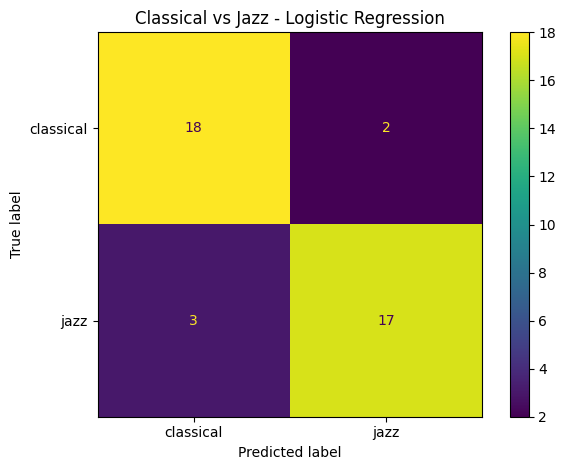

In [7]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["classical", "jazz"])
disp.plot(values_format='d')
plt.title("Classical vs Jazz - Logistic Regression")
plt.tight_layout()
plt.show()


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader



In [9]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_t = torch.tensor(y_train,        dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test,         dtype=torch.float32).view(-1, 1)


In [10]:
model = nn.Sequential(
    nn.Linear(40, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [11]:
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss = {loss.item():.4f}")


Epoch 10/40, Loss = 0.6252
Epoch 20/40, Loss = 0.5346
Epoch 30/40, Loss = 0.4208
Epoch 40/40, Loss = 0.3031


MLP Classification report:
              precision    recall  f1-score   support

   classical       0.95      0.95      0.95        20
        jazz       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



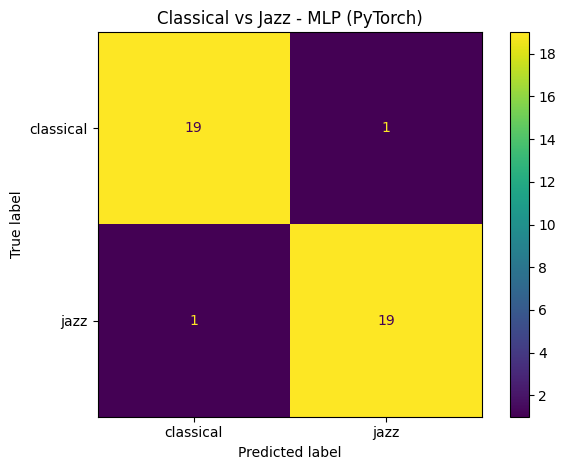

In [12]:
model.eval()
with torch.no_grad():
    y_proba = model(X_test_t)
    y_pred_mlp = (y_proba >= 0.5).int().numpy().flatten()

print("MLP Classification report:")
print(classification_report(y_test, y_pred_mlp, target_names=["classical", "jazz"]))

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(cm_mlp, display_labels=["classical", "jazz"])
disp.plot(values_format='d')
plt.title("Classical vs Jazz - MLP (PyTorch)")
plt.tight_layout()
plt.show()
